### Libraries and Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from google.colab import drive
from scipy.cluster.hierarchy import linkage, dendrogram

drive.mount('/content/drive')

Mounted at /content/drive


### Data Cleaning

Removing Missing Values and Duplicates

In [ ]:
def cleanDataset(df):
  print('\n\n')
  print('----------------------------------------------------------------------')
  print(inspect.currentframe().f_code.co_name)
  print('----------------------------------------------------------------------')
  print('\n\n')

  print(df.columns)

  # Assuming your DataFrame is named 'df'
  df.columns = [col.split(' [')[0] for col in df.columns]
  print('AFTER')
  print(df.columns)

  # print(df.head(53))
  print('Number of rows', df.shape[0])
  # df = df[df['Time Code'] != 'YR2022']
  # print(df.head(53))
  print('Number of rows', df.shape[0]) #Checking the number of rows in the Dataframe
  df = df[:-5] #Removing last 5 non-numerical coloumns
  df.replace('..', np.nan, inplace=True) #Replacing all empty '..' to nan


  #-----------Cleaning the Missing Values----------------------------------------#

  print("Missing Values BEFORE Cleaning")
  print(df.isnull().sum()) #Printing the number of missing values
  # Counting total missing values after cleaning
  print("Total Missing Values Before Cleaning")
  print(df.isnull().sum().sum())

  print("\n\n\n")

  for column in df.iloc[:, 4:]:
      df[column] = pd.to_numeric(df[column])

  # for column in df.columns: #Print the datatype of each column
  #         print(column, "---", df[column].dtype)


  for column in df.iloc[:, 4:]:
              df[column].fillna(df[column].mean(), inplace=True)

  print("Missing Values AFTER Cleaning")
  print(df.isnull().sum()) #Printing the number of missing values
  print("Total Missing Values After Cleaning")
  print(df.isnull().sum().sum())

  print("\n\n")
  #-----------Cleaning the Duplicate Values --------------------------------------#

  duplicate_rows = df[df.duplicated(subset=['Country Name', 'Time'], keep=False)]
  if(duplicate_rows.isnull):
    print("No Duplicates found")
  else:
      print("Duplicate Rows:")
      print(duplicate_rows)

      # Delete duplicate rows
      df.drop_duplicates(subset=['Country Name', 'Time'], keep='first', inplace=True)
      print("Duplicates deleted. Updated DataFrame:")
      print(df)

  print("\n\n")
  #--------------------------Cleaning Done--------------------------------------#
  print("DATA HAS BEEN CLEANED!!!")

  return df


### Normalization

In [ ]:
def normalizeDataset(df):
  print('\n\n')
  print('----------------------------------------------------------------------')
  print(inspect.currentframe().f_code.co_name)
  print('----------------------------------------------------------------------')
  print('\n\n')

  # Identify and drop non-numeric columns
  numeric_columns = df.select_dtypes(include=['number']).columns
  numeric_columns = numeric_columns.drop('Time')
  # Check if there are any non-numeric columns
  non_numeric_columns = set(df.columns) - set(numeric_columns)
  # If there are non-numeric columns, drop them before normalization
  if non_numeric_columns:
      df_numeric = df.drop(non_numeric_columns, axis=1)
  else:
      df_numeric = df.copy()


  # Create a StandardScaler instance
  scaler = StandardScaler()
  min_max_scaler = MinMaxScaler()
  robust_scaler = RobustScaler()
  maxabs_scaler = MaxAbsScaler()


  # Fit and transform the DataFrame
  standard = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)
  minmax = pd.DataFrame(min_max_scaler.fit_transform(df_numeric), columns=df_numeric.columns)
  robust = pd.DataFrame(robust_scaler.fit_transform(df_numeric), columns=df_numeric.columns)
  maxabs = pd.DataFrame(maxabs_scaler.fit_transform(df_numeric), columns=df_numeric.columns)
  fig = plt.figure(figsize=(10, 20))
  original = pd.DataFrame(df, columns=df_numeric.columns)
  plt.subplot(4, 1, 1)
  plt.plot(df.index, original)
  plt.title('Original')
  plt.xlabel('Time')

  # Plot the normalized time series using Standard Scaling
  plt.subplot(4, 1, 2)
  plt.plot(df.index, standard)
  plt.title('Standard Scaling')
  plt.xlabel('Time')

  # Plot the normalized time series using Standard Scaling
  plt.subplot(4, 1, 3)
  plt.plot(df.index, maxabs)
  plt.title('Max Abs Scaler')
  plt.xlabel('Time')

  # Plot the normalized time series using Min-Max Scaling
  plt.subplot(4, 1, 4)
  plt.plot(df.index, minmax)
  plt.title('Min-Max Scaling')
  plt.xlabel('Time')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


  plt.tight_layout()
  plt.show()

  normalized_df = standard
  standard_normalized = standard
  if non_numeric_columns:
      normalized_df = pd.concat([df[non_numeric_columns], normalized_df], axis=1)

  # print(normalized_df.head())

  return normalized_df

### Similarity Measures

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculateSimilarity(normalized_df):
  print('\n\n')
  print('----------------------------------------------------------------------')
  print(inspect.currentframe().f_code.co_name)
  print('----------------------------------------------------------------------')
  print('\n\n')
  new_df = normalized_df.drop('Time', axis=1)
  avg_values = new_df.groupby('Country Name').mean() #Calculating the mean of the values over the past 25 year for each country
  avg_values_transposed = avg_values.transpose() #Basically doing Dimensionality Reduction for heatmap

  # Calculate the cosine similarity
  similarity_matrix = cosine_similarity(avg_values_transposed)

  # Create a DataFrame from the similarity matrix
  similarity_df = pd.DataFrame(similarity_matrix, index=avg_values_transposed.index, columns=avg_values_transposed.index)

  import seaborn as sns
  import matplotlib.pyplot as plt

  # Set the size of the plot
  plt.figure(figsize=(12, 8))
  # Create a heatmap
  sns.heatmap(similarity_df, cmap="RdYlGn", annot=True, fmt=".2f", linewidths=.5)
  # Set the title and display the plot
  plt.title('Cosine Similarity Between Countries')
  plt.show()

  mask = np.triu(np.ones_like(similarity_df, dtype=bool))
  # Set the size of the plot
  plt.figure(figsize=(12, 8))
  # Create a heatmap
  sns.heatmap(similarity_df, cmap="RdYlGn", annot=True, fmt=".2f", linewidths=.5, mask = mask)
  # Set the title and display the plot
  plt.title('Cosine Similarity Between Countries')
  plt.show()

  return avg_values

### Feature Creation

In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame with the given columns
# Replace 'df' with the actual variable name if it's different

def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

def featureCreation(normalized_dataset):
  print('\n\n')
  print('----------------------------------------------------------------------')
  print(inspect.currentframe().f_code.co_name)
  print('----------------------------------------------------------------------')
  print('\n\n')
# Social Development Index (SDI)
  weights_social = {
      'Agricultural land (% of land area)': 0.25,
      'Access to electricity (% of population)': 0.25,
      'Life expectancy at birth, total (years)': 0.25,
      'Employment in agriculture (% of total employment) (modeled ILO estimate)': 0.25
  }

  # Initialize a new column 'SDI' with zeros
  normalized_dataset['SDI'] = 0
  # Iterate through the keys and add the weighted values to 'SDI' column
  for key, weight in weights_social.items():
    norm = normalize(normalized_dataset[key])
    normalized_dataset['SDI'] += (( norm * weight) * 100 )

  # Financial Development Index (FDI)
  weights_financial = {
      'GDP per capita (current US$)': 0.25,
      'Current account balance (BoP, current US$)': 0.25,
      'Total reserves (includes gold, current US$)': 0.25,
      'Net migration': 0.25
  }
  normalized_dataset['FDI'] = 0
  fdi = 0
  for key, weight in weights_financial.items():
    norm = normalize(normalized_dataset[key])
    normalized_dataset['FDI'] += (( norm * weight) * 100 )


  # Environmentally Friendly Index (EFI)
  weights_environmental = {
      'Forest area (% of land area)': 0.33,
      'CO2 emissions (metric tons per capita)': 0.33,
      'Urban population (% of total population)': 0.34
  }
  normalized_dataset['EFI'] = 0
  efi = 0
  for key, weight in weights_environmental.items():
    norm = normalize(normalized_dataset[key])
    if(key=='CO2 emissions (metric tons per capita)'):
      efi = efi - (( norm * weight) * 100 )
    else:
      efi = efi + (( norm * weight) * 100 )
    normalized_dataset['EFI'] = efi

  # Display the resulting DataFrame with new indices
  # print(normalized_dataset[['SDI', 'FDI', 'EFI']])
  added_features_dataset = normalized_dataset
  return added_features_dataset[['SDI', 'FDI', 'EFI', 'Country Name']]

### Graphs for New Features

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def graphsForNewFeatures(df):

  print('\n\n')
  print('----------------------------------------------------------------------')
  print(inspect.currentframe().f_code.co_name)
  print('----------------------------------------------------------------------')
  print('\n\n')

  # Group by country and calculate the average for SDI, FDI, EFI
  avg_indices_by_country = df.groupby('Country Name')[['Country Name', 'SDI', 'FDI', 'EFI']].mean()
  # Add 'Country' column
  avg_indices_by_country['Country'] = avg_indices_by_country.index

  # Reset index to make 'Country Name' a regular column
  avg_indices_by_country.reset_index(drop=True, inplace=True)

  # Now, avg_indices_by_country DataFrame has 'Country' column
  print(avg_indices_by_country)

  # Add lines with dots
  # Note the zorder to have dots be on top of the lines
  BROWN = "#AD8C97"
  BROWN_DARKER = "#7d3a46"
  GREEN = "#2FC1D3"
  BLUE = "#076FA1"
  GREY = "#C7C9CB"
  GREY_DARKER = "#5C5B5D"
  RED = "#E3120B"

  x = avg_indices_by_country['Country']

  y = avg_indices_by_country['SDI']
  plt.figure(figsize=(15, 30))
  plt.subplot(4,1,1)
  plt.plot(x, y, color=BROWN, lw=5)
  plt.scatter(x, y, fc=RED, s=100, lw=1.5, ec="white", zorder=12)
  plt.xlabel('Countries')
  plt.xticks([])
  for i, txt in enumerate(x):
      plt.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)


  y = avg_indices_by_country['FDI']
  plt.figure(figsize=(15, 30))
  plt.subplot(4,1,1)
  plt.plot(x, y, color=GREEN, lw=5)
  plt.scatter(x, y, fc=RED, s=100, lw=1.5, ec="white", zorder=12)
  plt.xlabel('Countries')
  plt.xticks([])
  for i, txt in enumerate(x):
      plt.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

  y = avg_indices_by_country['EFI']
  plt.figure(figsize=(15, 30))
  plt.subplot(4,1,1)
  plt.plot(x, y, color=GREY, lw=5)
  plt.scatter(x, y, fc=RED, s=100, lw=1.5, ec="white", zorder=12)
  plt.xlabel('Countries')
  plt.xticks([])
  for i, txt in enumerate(x):
      plt.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)


  # print(avg_indices_by_country)
  # Plotting
  plt.figure(figsize=(15, 8))
  plt.plot(avg_indices_by_country['Country'], avg_indices_by_country['SDI'], label='SDI', marker='o', color='blue')
  plt.plot(avg_indices_by_country['Country'], avg_indices_by_country['FDI'], label='FDI', marker='o', color='green')
  plt.plot(avg_indices_by_country['Country'], avg_indices_by_country['EFI'], label='EFI', marker='o', color='orange')

  # Adding labels and title
  plt.xlabel('Country')
  plt.ylabel('Index Value')
  plt.title('Social, Financial, and Economic Indicators by Country')
  plt.xticks(rotation=90)
  plt.legend()

  # Display the plot
  plt.tight_layout()
  plt.show()
  return avg_indices_by_country


### Clustering

In [ ]:
def kMeansCountries(normalized_dataset, clusters):
  print('\n\n')
  print('----------------------------------------------------------------------')
  print(inspect.currentframe().f_code.co_name)
  print('----------------------------------------------------------------------')
  print('\n\n')

  grouped =  normalized_dataset.groupby('Country Name').mean()
  grouped = grouped.drop('Time', errors='ignore')
  grouped = grouped.drop('Time Code', errors='ignore')
  numeric_columns = grouped.select_dtypes(include=['number']).columns

  # Add 'Country' column
  grouped['Country'] = grouped.index
  # Reset index to make 'Country Name' a regular column
  grouped.reset_index(drop=True, inplace=True)

    # Check if there are any non-numeric columns
  non_numeric_columns = set(grouped.columns) - set(numeric_columns)
    # If there are non-numeric columns, drop them before normalization
  if non_numeric_columns:
        df_numeric = grouped.drop(non_numeric_columns, axis=1)
  else:
        df_numeric = grouped.copy()

  # K-means clustering
  kmeans = KMeans(n_clusters=clusters, random_state=42)
  df_numeric['Cluster'] = kmeans.fit_predict(df_numeric)

  silhouette_avg = silhouette_score(df_numeric, df_numeric['Cluster'])
  print(f"Silhouette Score for {clusters} clusters:", silhouette_avg)

  sse = kmeans.inertia_
  print(f"SSE for {clusters} clusters:", sse)

  # PCA
  pca = PCA(n_components=2)
  data_pca = pca.fit_transform(df_numeric)
  df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'], index=df_numeric.index)
  df_pca['Cluster'] = df_numeric['Cluster']
  df_pca['Country'] = grouped['Country']

  # Plot the clusters
  plt.figure(figsize=(10, 6))
  for cluster in df_numeric['Cluster'].unique():
      cluster_data = df_pca[df_pca['Cluster'] == cluster]
      plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')
      for i, country in enumerate(cluster_data['Country']):
            plt.text(cluster_data['PC1'].iloc[i], cluster_data['PC2'].iloc[i], country, fontsize=8)

  plt.title('K-means Clustering')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.legend()
  plt.show()



### Cluster Validity - SSE

In [ ]:
import matplotlib.pyplot as plt

def showValidityOfCluster():
  print('\n\n')
  print('----------------------------------------------------------------------')
  print(inspect.currentframe().f_code.co_name)
  print('----------------------------------------------------------------------')
  print('\n\n')
  sse_values = [5419.972, 4004.388, 3135.370, 2419.624 ,1974.853, 1774.605]
  num_clusters = [2, 3, 4, 5,6,7]

  plt.plot(num_clusters, sse_values, marker='o')
  plt.title('Elbow Method for Optimal Cluster Selection')
  plt.xlabel('Number of Clusters')
  plt.ylabel('SSE')
  plt.show()


### Hierarchal Clustering

In [ ]:
def hierarchicalClusteringCountries(normalized_dataset, method):
    print('\n\n')
    print('----------------------------------------------------------------------')
    print(inspect.currentframe().f_code.co_name)
    print('----------------------------------------------------------------------')
    print('\n\n')

    grouped = normalized_dataset.groupby('Country Name').mean()
    numeric_columns = grouped.select_dtypes(include=['number']).columns

    # Add 'Country' column
    grouped['Country'] = grouped.index
    # Reset index to make 'Country Name' a regular column
    grouped.reset_index(drop=True, inplace=True)

    # Check if there are any non-numeric columns
    non_numeric_columns = set(grouped.columns) - set(numeric_columns)
    # If there are non-numeric columns, drop them before normalization
    if non_numeric_columns:
        df_numeric = grouped.drop(non_numeric_columns, axis=1)
    else:
        df_numeric = grouped.copy()

    # Standardize the data
    scaler = StandardScaler()
    df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric[numeric_columns]), columns=numeric_columns)
    # print(df_numeric_scaled)

    # Hierarchical clustering
    linkage_matrix = linkage(df_numeric_scaled, method=method)
    # print(linkage_matrix)

    # Plot the dendrogram
    plt.figure(figsize=(15, 8))
    dendrogram(linkage_matrix, labels=grouped['Country'].tolist(), orientation='top', distance_sort='descending', leaf_font_size=10)
    plt.title('Hierarchical Clustering Dendrogram - ' + method)
    plt.xlabel('Countries')
    plt.ylabel('Distance')
    plt.show()

### Attribute VS Countries over last 15 years

In [ ]:
def showAttributsVsCountryOverTime(df, attribute):
  print('\n\n')
  print('----------------------------------------------------------------------')
  print(inspect.currentframe().f_code.co_name)
  print('----------------------------------------------------------------------')
  print('\n\n')
  # Extract relevant columns for plotting
  df_plot = df[['Country Name', 'Time', attribute]]

  # Aggregate the values (mean) for any duplicate entries
  df_plot = df_plot.groupby(['Country Name', 'Time']).mean().reset_index()

  # Pivot the DataFrame for better plotting
  df_plot_pivot = df_plot.pivot(index='Time', columns='Country Name', values=attribute)

  ############ANIMATE THIS PLOT ################
  # Plotting
  # Generate a colormap with a number of colors equal to the number of countries
  colors = plt.cm.get_cmap('tab10', len(df_plot_pivot.columns))
  plt.figure(figsize=(14, 130), dpi=200)
  ax = df_plot_pivot.plot(marker='.', linestyle='-', linewidth=2,  colormap=colors)
  ax.get_legend().remove()  # Remove legend
  plt.title(attribute + ', all countries over last 15 years')
  plt.xlabel('Year')
  plt.ylabel(attribute)

  # Add country names beside the lines
  for country_name in df_plot_pivot.columns:
      last_value = df_plot_pivot[country_name].dropna().iloc[-1]
      plt.annotate(country_name, xy=(df_plot_pivot.index[-1], last_value),
                  xytext=(5, 0), textcoords='offset points', ha='left', va='center', rotation=30)
  plt.show()



### Comparision of Continents

In [ ]:
import inspect
def getContinentStats(df, plotOrNot):
    print('\n\n')
    print('----------------------------------------------------------------------')
    print(inspect.currentframe().f_code.co_name)
    print('----------------------------------------------------------------------')
    print('\n\n')
    unique_values = df['Country Name'].unique()
    country_to_continent = {
        'Afghanistan': 'Asia',
        'Argentina': 'South America',
        'Australia': 'Oceania',
        'Bangladesh': 'Asia',
        'Brazil': 'South America',
        'Canada': 'North America',
        'Chile': 'South America',
        'China': 'Asia',
        'Cuba': 'North America',
        'Denmark': 'Europe',
        'Ethiopia': 'Africa',
        'Finland': 'Europe',
        'France': 'Europe',
        'Germany': 'Europe',
        'Iceland': 'Europe',
        'India': 'Asia',
        'Japan': 'Asia',
        'Libya': 'Africa',
        'New Zealand': 'Oceania',
        'Nigeria': 'Africa',
        'Pakistan': 'Asia',
        'Russian Federation': 'Europe',
        'South Africa': 'Africa',
        'Saudi Arabia': 'Asia',
        'Sri Lanka': 'Asia',
        'Ukraine': 'Europe',
        'United Kingdom': 'Europe',
        'Venezuela, RB': 'South America',
        'Zimbabwe': 'Africa'
    }
    df['Continent'] = df['Country Name'].map(country_to_continent)

    # Group by continent and Time and calculate mean for each indicator
    continent_time_stats = df.groupby(['Continent', 'Time']).mean()

    if(plotOrNot==True):
      # Selecting columns from the 5th column onwards
      columns_to_plot = df.columns[4:-3]
      # Iterate over columns_to_plot using enumerate
      for i, column in enumerate(columns_to_plot):
          # Create a new plot for each column
          fig, ax = plt.subplots(figsize=(12, 6))

          # Plot the data for each continent
          continent_time_stats[column].unstack(level=0).plot(kind='bar', ax=ax)

          # Set plot title and labels
          ax.set_title(column)
          ax.set_ylabel('Value')

          # Show the plot
          plt.show()

    return continent_time_stats



### Story with Continents

In [ ]:
def tellAStorywithTimeContinents(continent_stats, continents, feature, start_year, end_year):
    plt.figure(figsize=(10, 6))

    for continent in continents:
        continent_data = continent_stats.loc[continent]
        mask = (continent_data.index.get_level_values('Time') >= start_year) & (continent_data.index.get_level_values('Time') <= end_year)
        plt.bar(continent_data.index.get_level_values('Time')[mask], continent_data[feature][mask], label=continent)

    # Adding labels and title
    plt.title(feature)
    plt.xlabel('Year')
    plt.ylabel(feature)

    # Display the legend
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()


### Story with Countries

In [ ]:
def tellAStorywithCountries(dataset, countries, feature, start_year, end_year):
    plt.figure(figsize=(10, 6))

    for country in countries:
        country_gdp = dataset[(dataset['Country Name'] == country) & (dataset['Time'] >= start_year) & (dataset['Time'] <= end_year)][[feature, 'Time']]
        plt.plot(country_gdp['Time'], country_gdp[feature], marker='o', linestyle='-', label=country)

    # Adding labels and title
    plt.title(feature)
    plt.xlabel('Year')
    plt.ylabel(feature)

    # Display the legend
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()

### Run Pre-processing




----------------------------------------------------------------------
cleanDataset
----------------------------------------------------------------------



Index(['Country Name', 'Country Code', 'Time', 'Time Code',
       'Access to electricity (% of population) [EG.ELC.ACCS.ZS]',
       'Agricultural land (% of land area) [AG.LND.AGRI.ZS]',
       'Employment in agriculture (% of total employment) (modeled ILO estimate) [SL.AGR.EMPL.ZS]',
       'Urban population (% of total population) [SP.URB.TOTL.IN.ZS]',
       'CO2 emissions (metric tons per capita) [EN.ATM.CO2E.PC]',
       'Forest area (% of land area) [AG.LND.FRST.ZS]',
       'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
       'GDP per capita (current US$) [NY.GDP.PCAP.CD]',
       'Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]',
       'Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]',
       'Net migration [SM.POP.NETM]',
       'Population growth (annual %) [SP.POP.GROW]'

<ipython-input-3-6004387cf619>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('..', np.nan, inplace=True) #Replacing all empty '..' to nan
<ipython-input-3-6004387cf619>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column])
<ipython-input-3-6004387cf619>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].fillna(df[column]

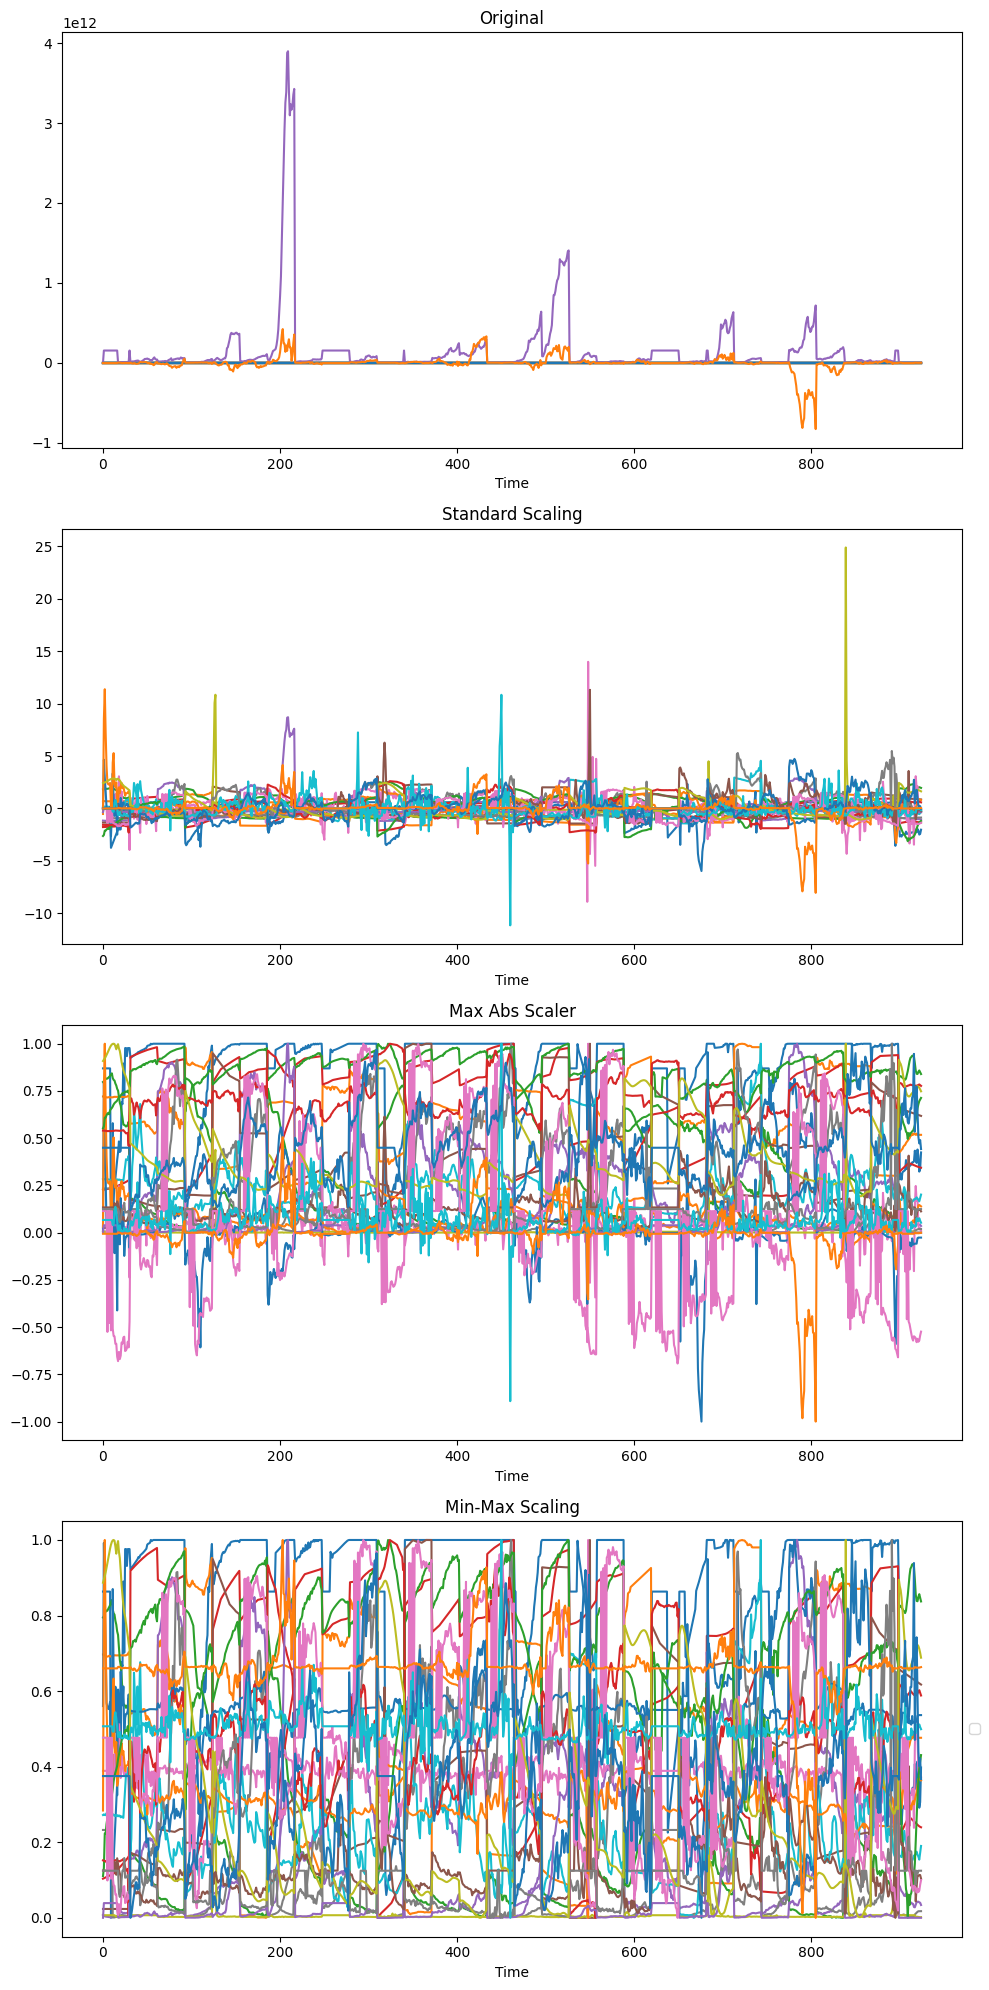

<ipython-input-4-87feaf2dca52>:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  normalized_df = pd.concat([df[non_numeric_columns], normalized_df], axis=1)
<ipython-input-5-7569a2599733>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_values = new_df.groupby('Country Name').mean() #Calculating the mean of the values over the past 25 year for each country





----------------------------------------------------------------------
calculateSimilarity
----------------------------------------------------------------------





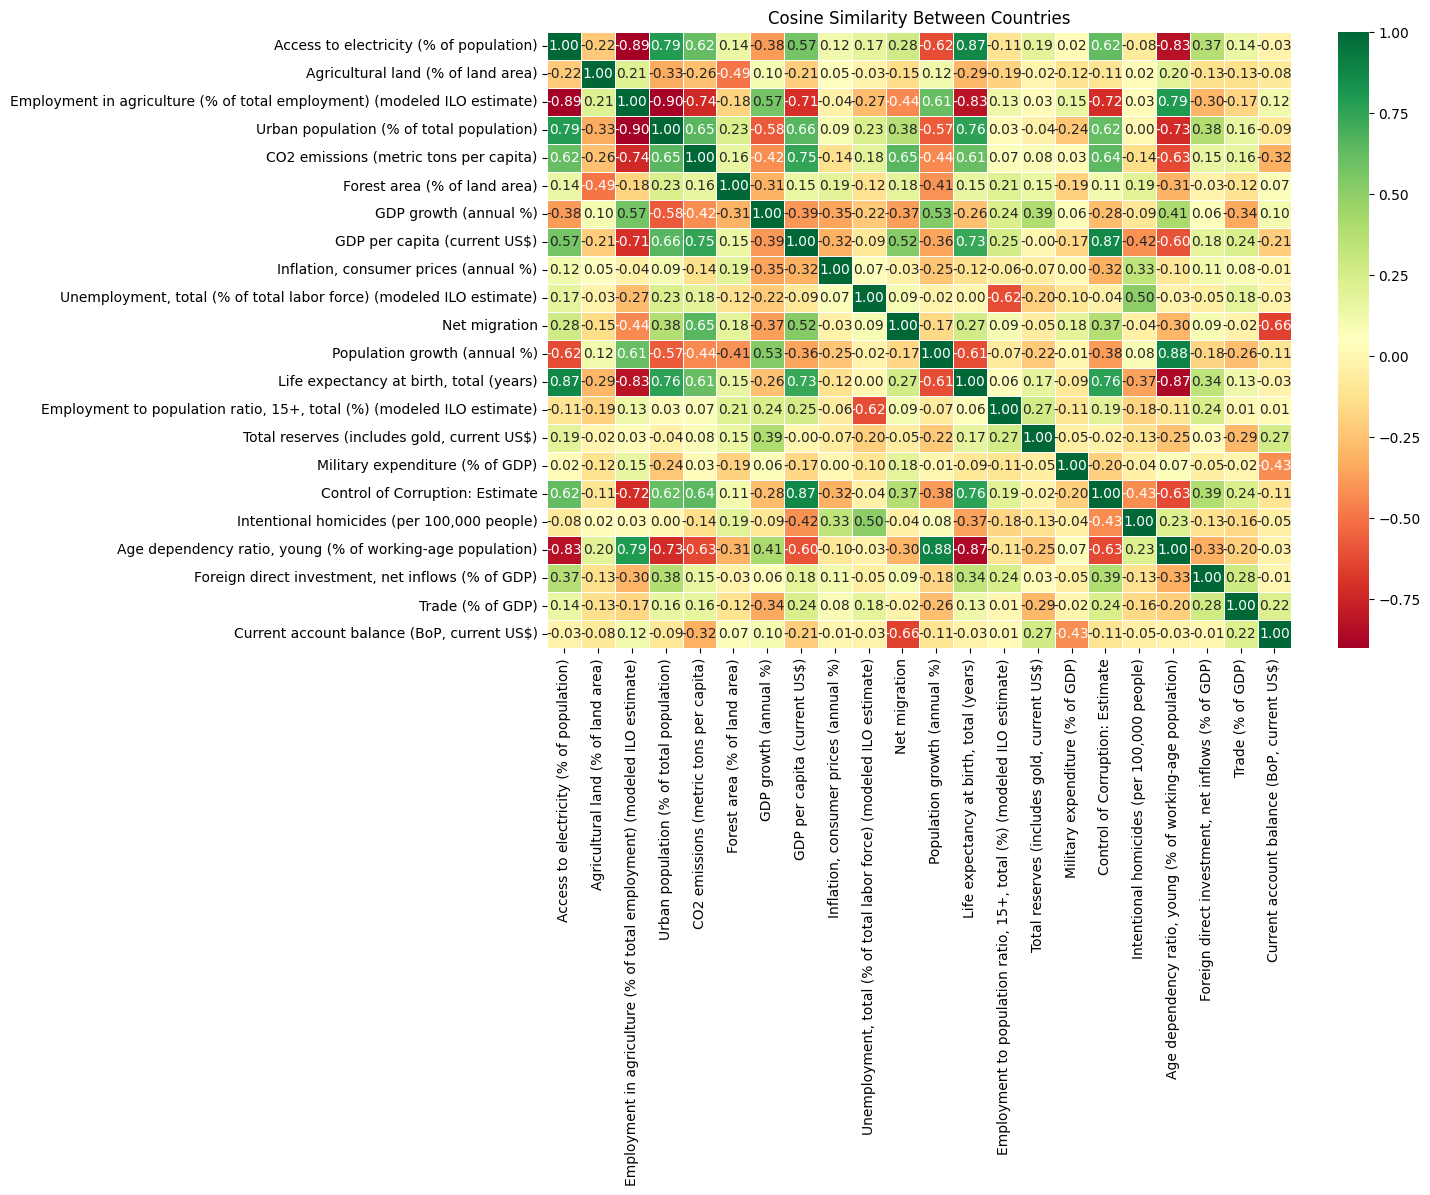

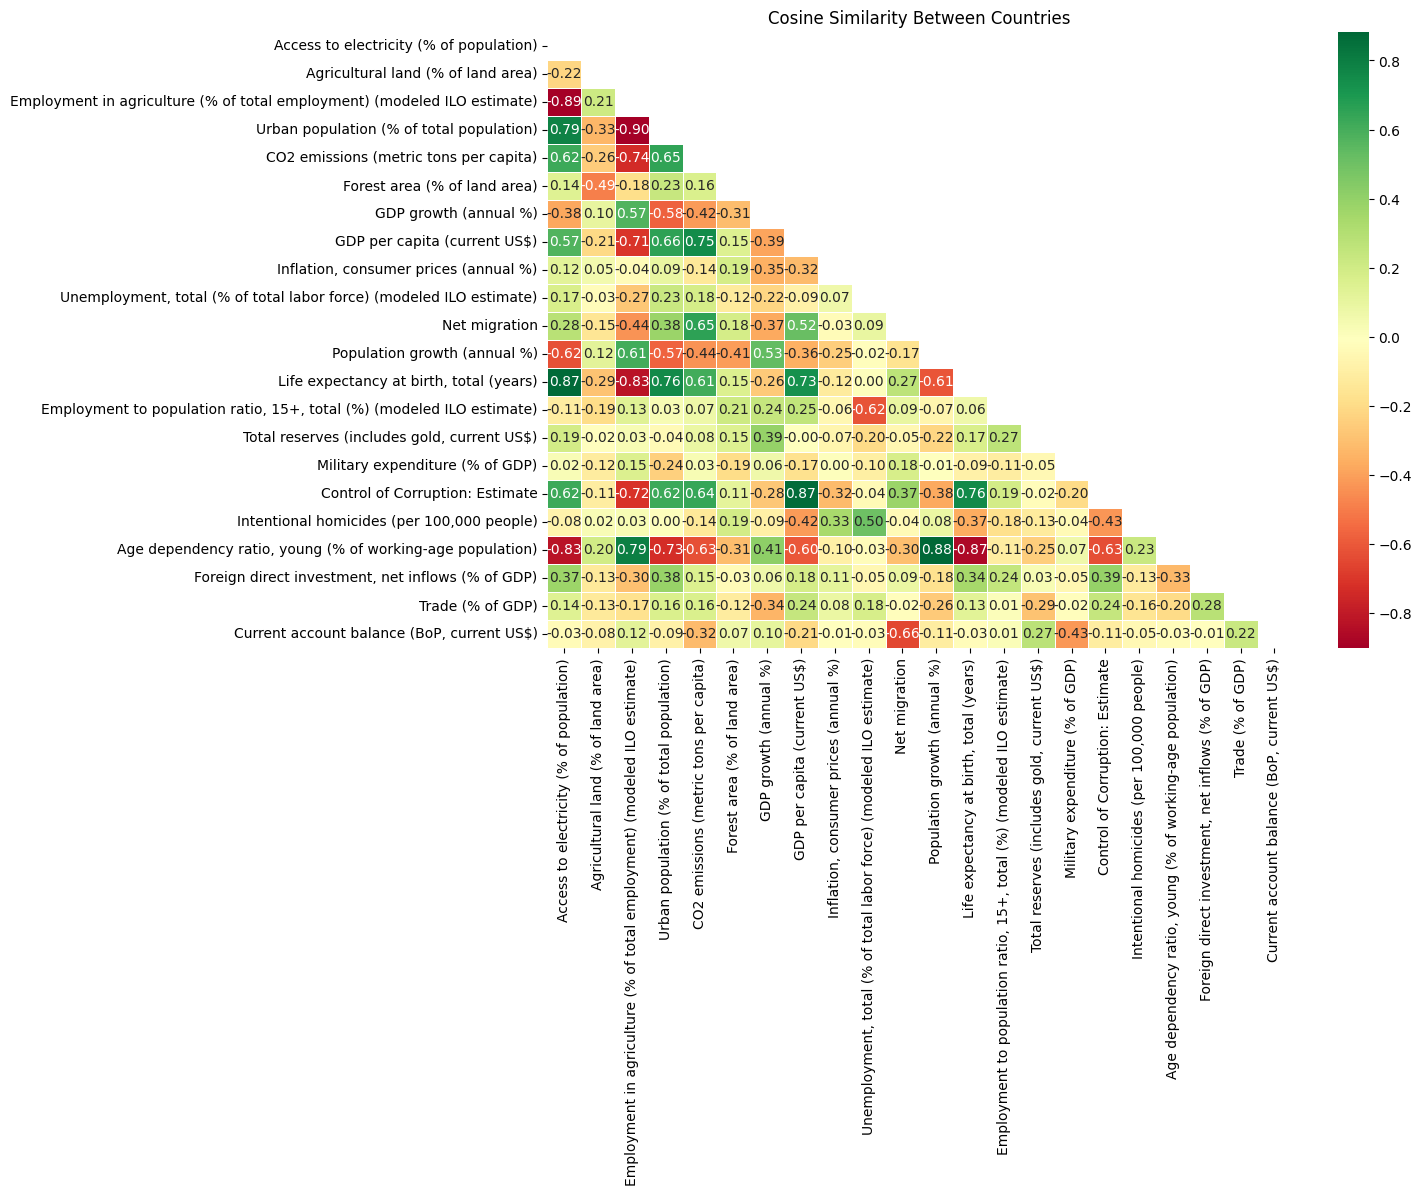




----------------------------------------------------------------------
featureCreation
----------------------------------------------------------------------






----------------------------------------------------------------------
graphsForNewFeatures
----------------------------------------------------------------------



          SDI        FDI        EFI                    Country
0   60.237901  33.747297   4.598372                Afghanistan
1   59.958703  33.308874  31.377973                  Argentina
2   64.364005  43.955661  11.179179                  Australia
3   64.522515  28.124482  12.249083                 Bangladesh
4   52.809478  33.123194  54.505046                     Brazil
5   47.930052  43.592570  20.401337                     Canada
6   53.396937  33.835805  34.715608                      Chile
7   72.196218  42.376663  14.509865                      China
8   68.869914  32.832952  33.988441                       Cuba
9   67.207080  46.892463  22.703360  

<ipython-input-7-b6ff72a9ea1c>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_indices_by_country = df.groupby('Country Name')[['Country Name', 'SDI', 'FDI', 'EFI']].mean()


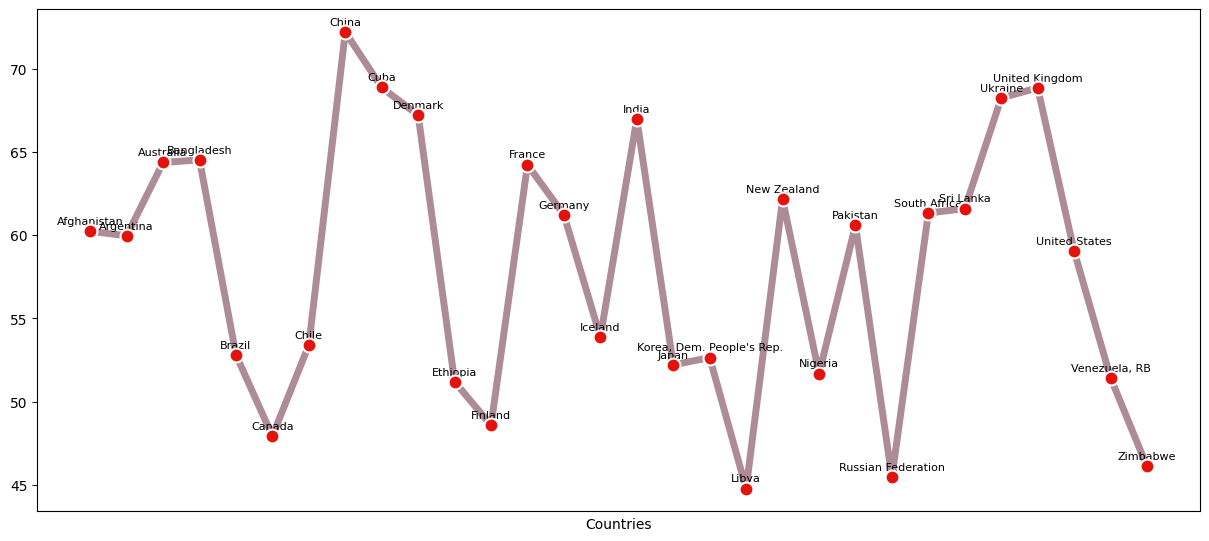

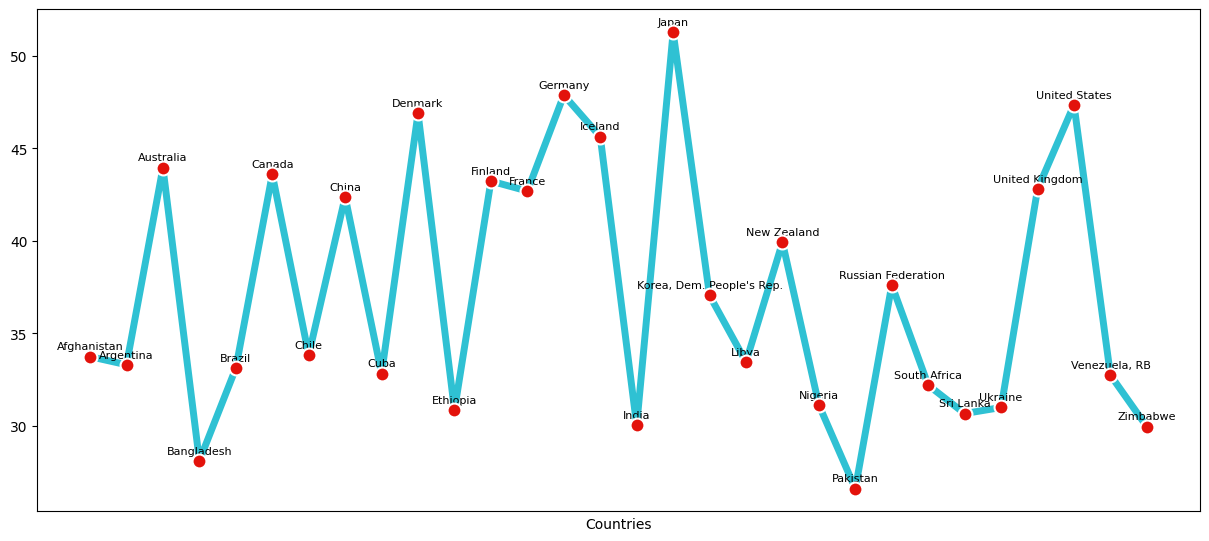

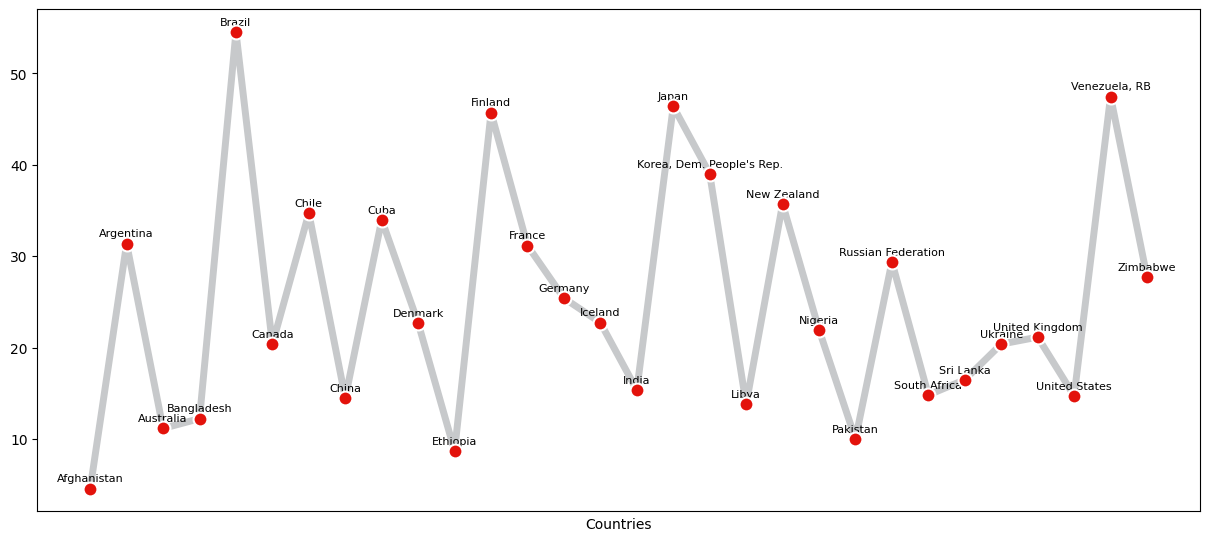

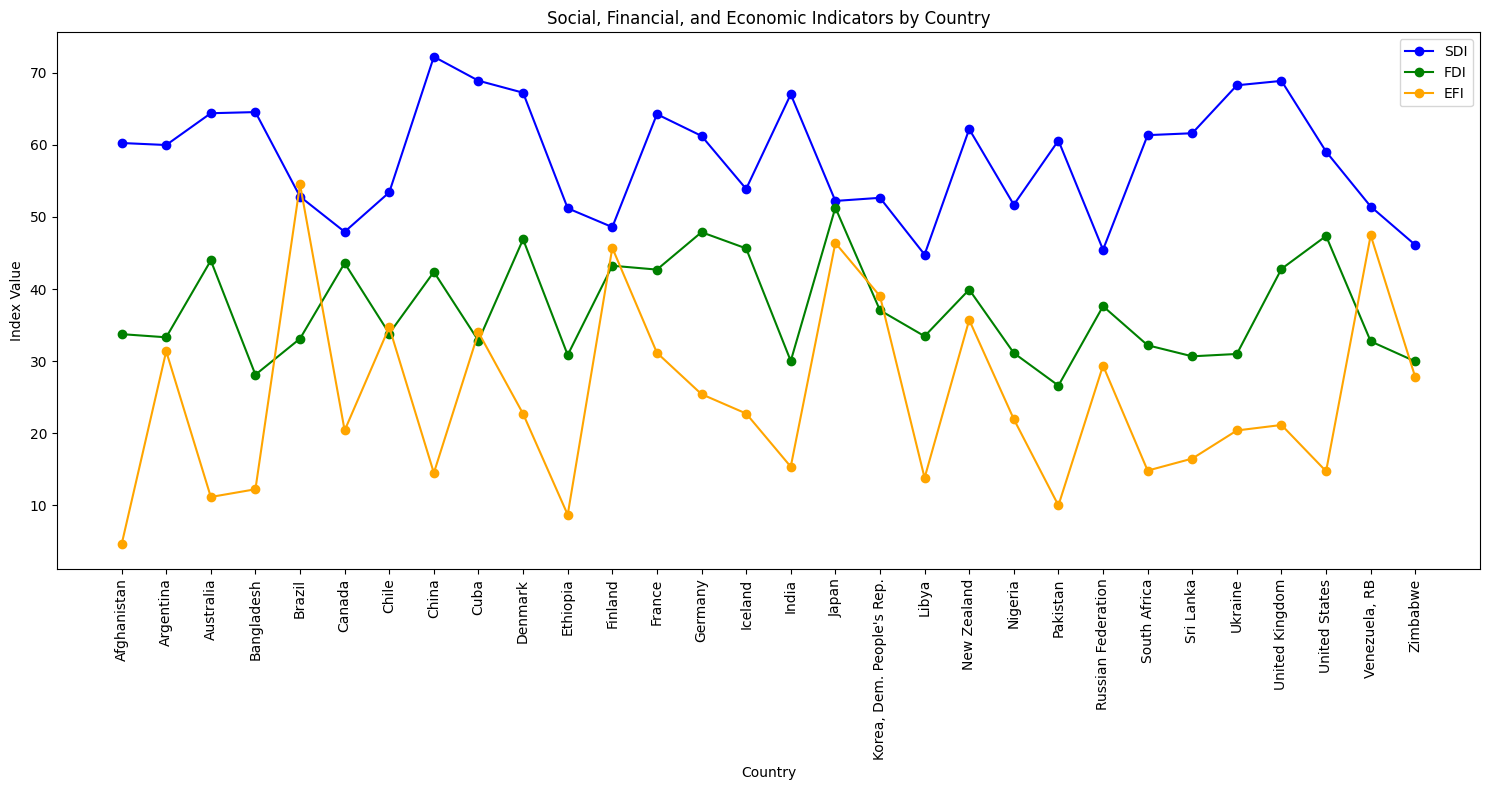

In [ ]:
dataset_file = "/content/drive/MyDrive/ada/dataset13.csv"
df = pd.read_csv(dataset_file)

cleaned_dataset = cleanDataset(df)
normalized_dataset = normalizeDataset(cleaned_dataset)
grouped_country_dataset = calculateSimilarity(normalized_dataset)

added_features_dataset = featureCreation(normalized_dataset)
grouped_country_new_features = graphsForNewFeatures(added_features_dataset)

### Run Clustering




----------------------------------------------------------------------
kMeansCountries
----------------------------------------------------------------------



Silhouette Score for 2 clusters: 0.3419021962936221
SSE for 2 clusters: 4774.262370119546


<ipython-input-8-7a80f27e239e>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped =  normalized_dataset.groupby('Country Name').mean()
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


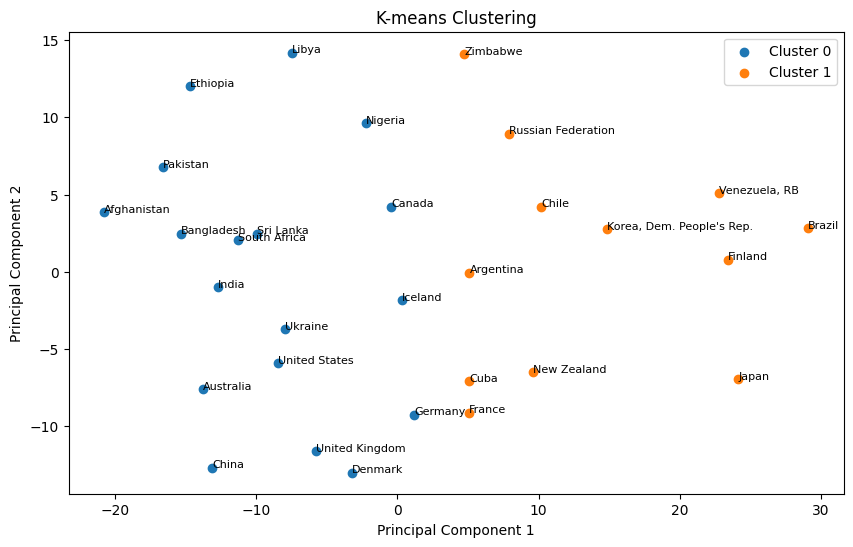




----------------------------------------------------------------------
kMeansCountries
----------------------------------------------------------------------



Silhouette Score for 3 clusters: 0.31126785352073016
SSE for 3 clusters: 3559.8842910624235


<ipython-input-8-7a80f27e239e>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped =  normalized_dataset.groupby('Country Name').mean()
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


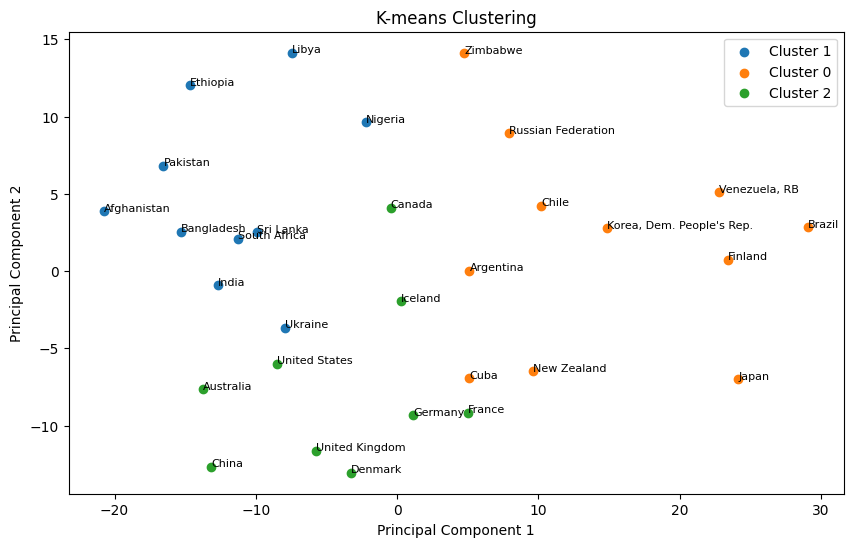




----------------------------------------------------------------------
kMeansCountries
----------------------------------------------------------------------



Silhouette Score for 4 clusters: 0.2984500918778642
SSE for 4 clusters: 2811.5497664069417


<ipython-input-8-7a80f27e239e>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped =  normalized_dataset.groupby('Country Name').mean()
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


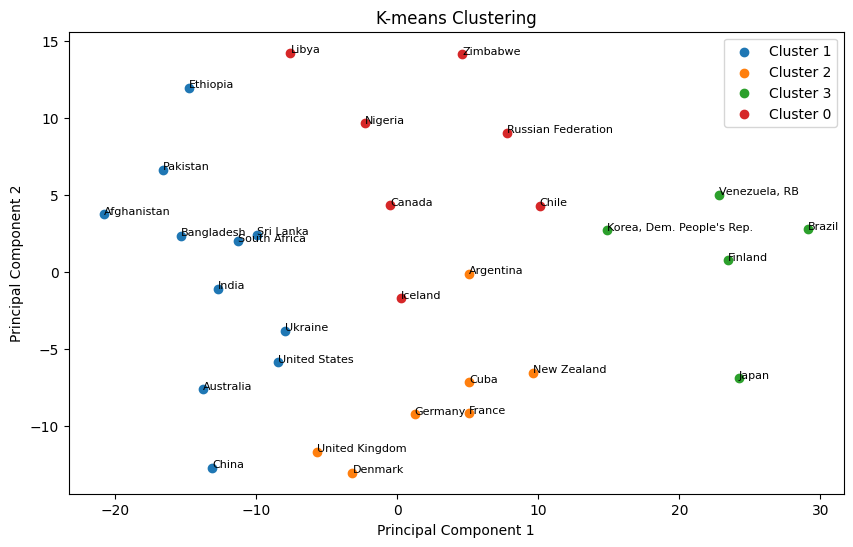




----------------------------------------------------------------------
kMeansCountries
----------------------------------------------------------------------



Silhouette Score for 5 clusters: 0.3260980548471632
SSE for 5 clusters: 2078.072553103987


<ipython-input-8-7a80f27e239e>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped =  normalized_dataset.groupby('Country Name').mean()
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


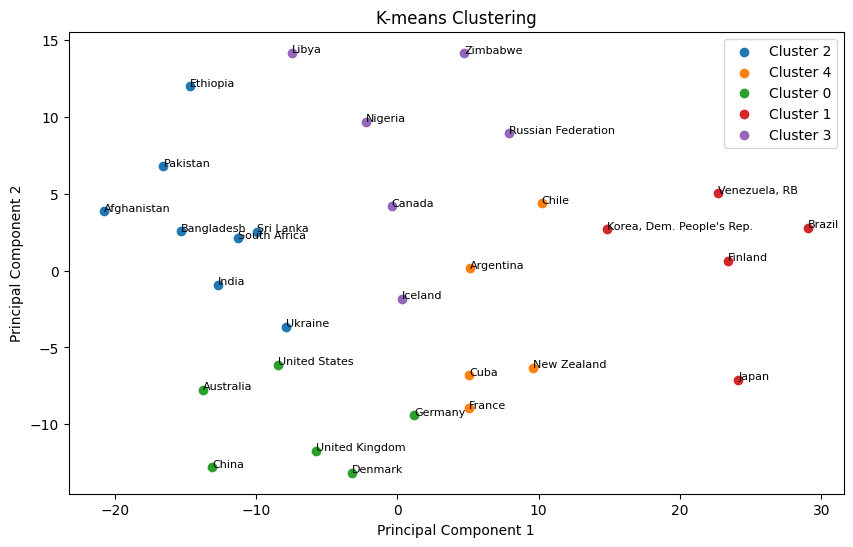




----------------------------------------------------------------------
showValidityOfCluster
----------------------------------------------------------------------





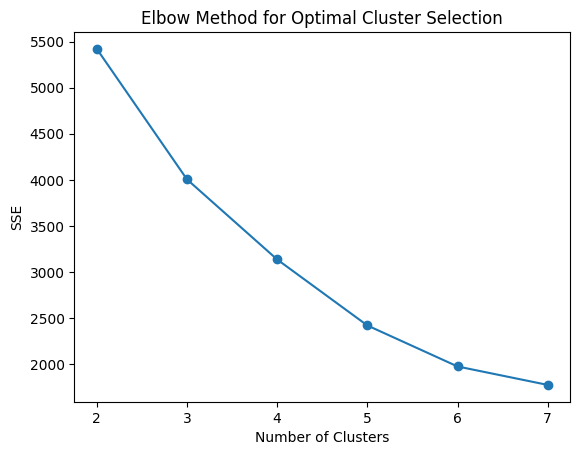




----------------------------------------------------------------------
hierarchicalClusteringCountries
----------------------------------------------------------------------





<ipython-input-10-227f8aacc0f9>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = normalized_dataset.groupby('Country Name').mean()


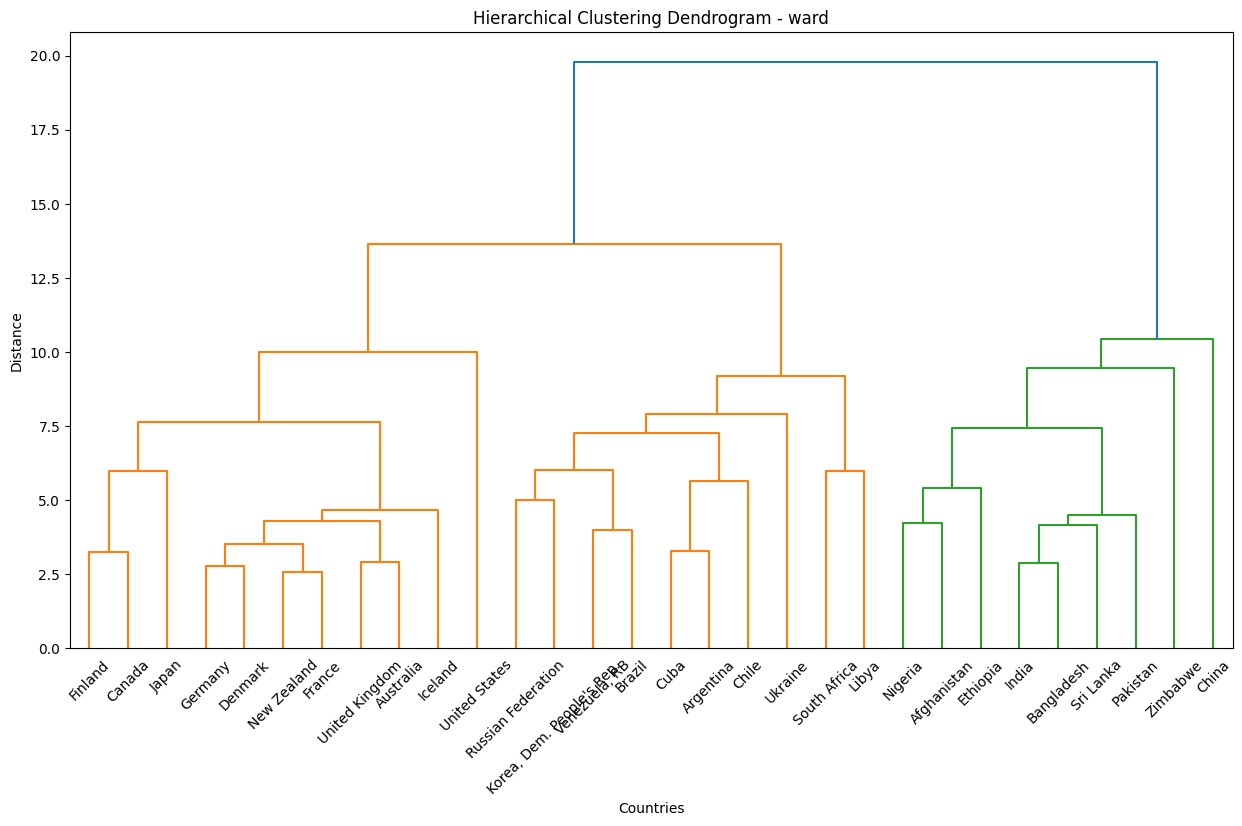




----------------------------------------------------------------------
hierarchicalClusteringCountries
----------------------------------------------------------------------





<ipython-input-10-227f8aacc0f9>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = normalized_dataset.groupby('Country Name').mean()


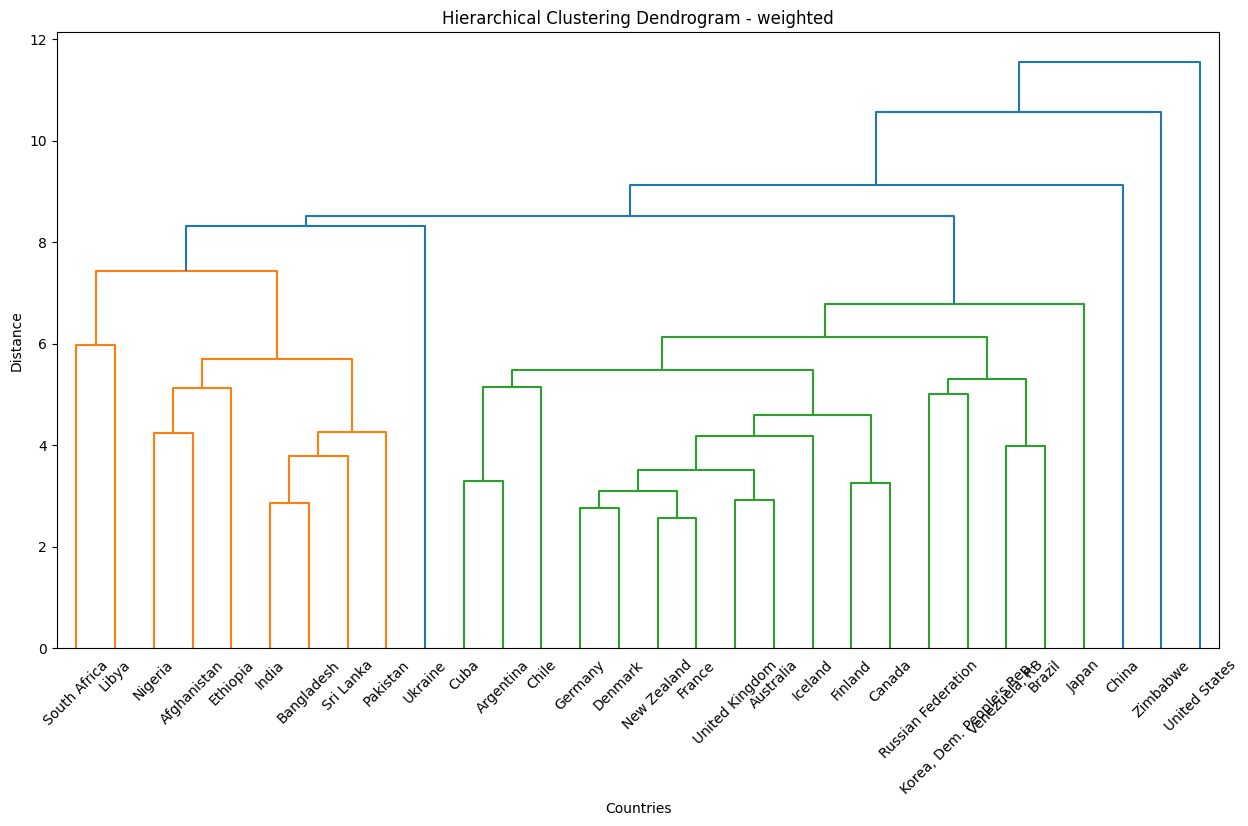




----------------------------------------------------------------------
hierarchicalClusteringCountries
----------------------------------------------------------------------





<ipython-input-10-227f8aacc0f9>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = normalized_dataset.groupby('Country Name').mean()


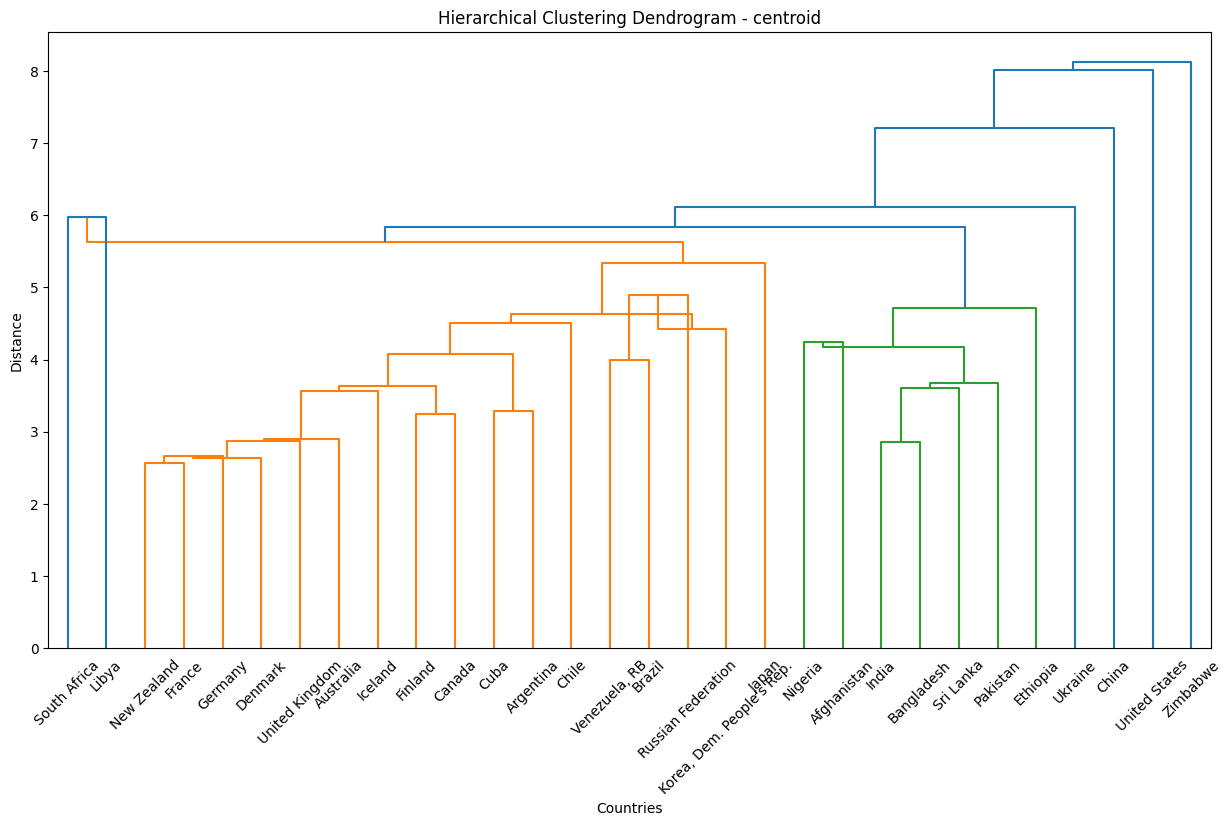

In [ ]:
kMeansCountries(normalized_dataset, 2)
kMeansCountries(normalized_dataset, 3)
kMeansCountries(normalized_dataset, 4)
kMeansCountries(normalized_dataset, 5)
showValidityOfCluster()
hierarchicalClusteringCountries(normalized_dataset, 'ward')
hierarchicalClusteringCountries(normalized_dataset, 'weighted')
hierarchicalClusteringCountries(normalized_dataset, 'centroid')

### Run Stories

Index(['Country Name', 'Country Code', 'Time', 'Time Code',
       'Access to electricity (% of population)',
       'Agricultural land (% of land area)',
       'Employment in agriculture (% of total employment) (modeled ILO estimate)',
       'Urban population (% of total population)',
       'CO2 emissions (metric tons per capita)',
       'Forest area (% of land area)', 'GDP growth (annual %)',
       'GDP per capita (current US$)', 'Inflation, consumer prices (annual %)',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)',
       'Net migration', 'Population growth (annual %)',
       'Life expectancy at birth, total (years)',
       'Employment to population ratio, 15+, total (%) (modeled ILO estimate)',
       'Total reserves (includes gold, current US$)',
       'Military expenditure (% of GDP)', 'Control of Corruption: Estimate',
       'Intentional homicides (per 100,000 people)',
       'Age dependency ratio, young (% of working-age population)',
  

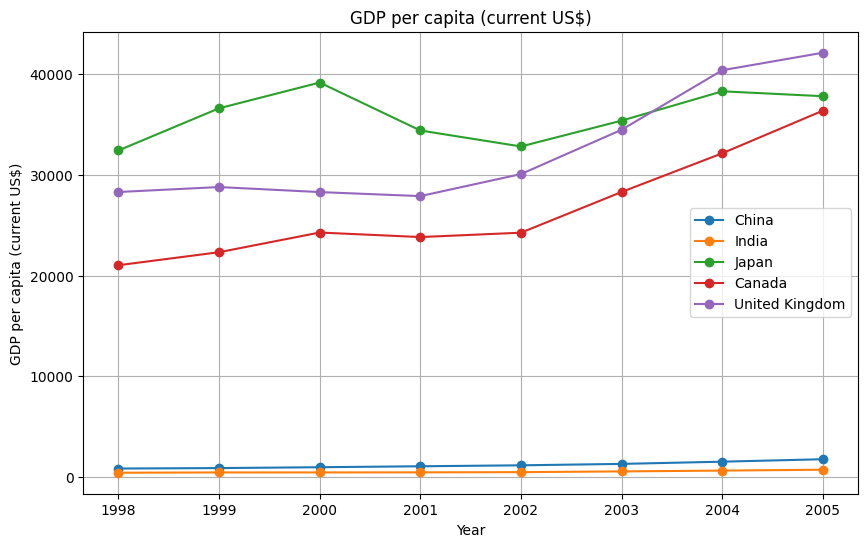



-------------------Brexit-----------------


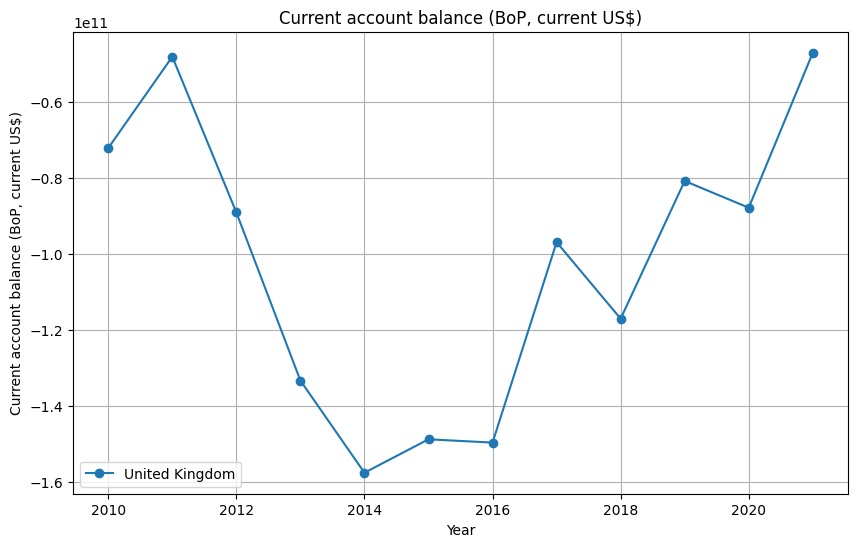



-------------------Pandemic-----------------



----------------------------------------------------------------------
getContinentStats
----------------------------------------------------------------------





<ipython-input-12-e6f68b9c0183>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Continent'] = df['Country Name'].map(country_to_continent)
<ipython-input-12-e6f68b9c0183>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  continent_time_stats = df.groupby(['Continent', 'Time']).mean()


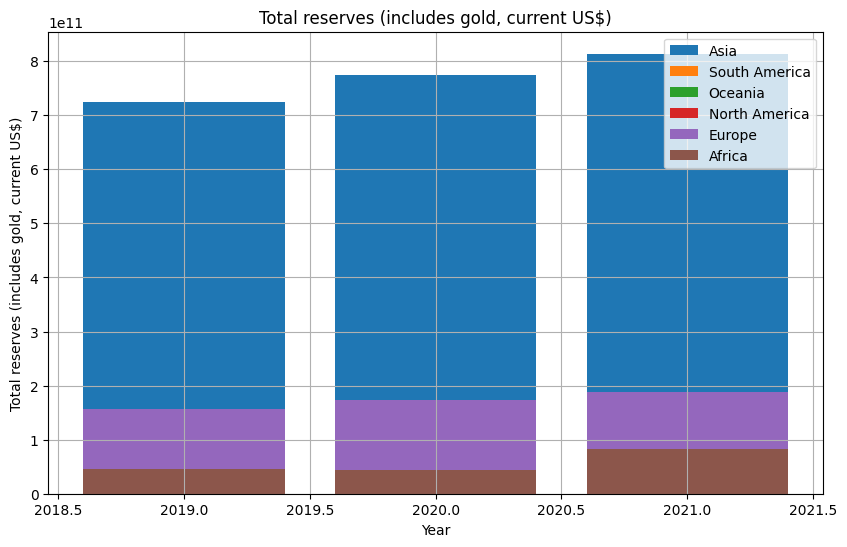

In [ ]:
print(cleaned_dataset.columns)
print("-------------------Chinas Economic Rise-----------------")
countries = ['China', 'India', 'Japan', 'Canada', 'United Kingdom']
feature = 'GDP per capita (current US$)'
tellAStorywithCountries(cleaned_dataset, countries, feature, 1998, 2005)

print("\n\n-------------------Brexit-----------------")
countries = ['United Kingdom']
feature = 'Current account balance (BoP, current US$)'
tellAStorywithCountries(cleaned_dataset, countries, feature, 2010, 2022)

print("\n\n-------------------Pandemic-----------------")
countries = [
    "Afghanistan", "Argentina", "Australia", "Bangladesh", "Brazil", "Canada",
    "Chile", "China", "Cuba", "Denmark", "Ethiopia", "Finland", "France",
    "Germany", "Iceland", "India", "Japan", "Libya", "New Zealand", "Nigeria",
    "Pakistan", "Russian Federation", "Saudi Arabia", "South Africa", "Sri Lanka",
    "Ukraine", "United Kingdom", "Venezuela, RB", "Zimbabwe"
]
feature = 'Total reserves (includes gold, current US$)'
continents = ['Asia', 'South America', 'Oceania', 'North America', 'Europe', 'Africa']
tellAStorywithTimeContinents(getContinentStats(cleaned_dataset, False), continents, feature, 2019, 2022)


### test

In [ ]:
print('Yo')

Yo
